# Question 2

In [102]:
# Importation des librairies de base
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from datetime import datetime
import statsmodels.api as sm
import argparse

# a - ii
from statsmodels.tsa.stattools import adfuller, kpss

#b - i 
from statsmodels.tsa.api import VAR
from statsmodels.tsa.stattools import grangercausalitytests

In [26]:
import warnings
warnings.filterwarnings('ignore')

## a - i

In [48]:
# Définition fonction simulation AR
def simulate_ar(n=200, phi=None, mu=0, sigma=1, y0=0, seed=None):
    if seed is not None:
        np.random.seed(seed)
    
    # Génération des erreurs i.i.d.
    errors = np.random.normal(0, sigma, n)
    
    if phi is None:
        phi = []
    else:
        phi = np.array(phi)
    
    p = len(phi)  
    y = np.zeros(n)
    
    # Conditions initiales
    if isinstance(y0, (list, np.ndarray)):
        y[:p] = y0
    else:
        y[:p] = y0
    
    # Simulation AR(p)
    for t in range(p, n):
        y[t] = mu
        for i in range(p):
            y[t] += phi[i] * y[t-1-i]
        y[t] += errors[t]
    
    return y

In [ ]:
# Simulation des 5 séries AR - même seed pour discussion résultats
np.random.seed(42)

# Série 1: y_t = y_{t-1} + e_t (marche aléatoire)
y1 = simulate_ar(n=200, phi=[1.0], mu=0, seed=42)

# Série 2: y_t = 0.98*y_{t-1} + e_t (proche racine unitaire)
y2 = simulate_ar(n=200, phi=[0.98], mu=0, seed=43)

# Série 3: y_t = 0.90*y_{t-1} + e_t (AR(1) stationnaire)
y3 = simulate_ar(n=200, phi=[0.90], mu=0, seed=44)

# Série 4: y_t = 0.1 + y_{t-1} + e_t (Marche aléatoire avec drift)
y4 = simulate_ar(n=200, phi=[1.0], mu=0.1, seed=45)

# Série 5: y_t = 1.25*y_{t-1} - 0.27*y_{t-2} + e_t (AR(2) racine unitaire)
y5 = simulate_ar(n=200, phi=[1.25, -0.27], mu=0, seed=46)

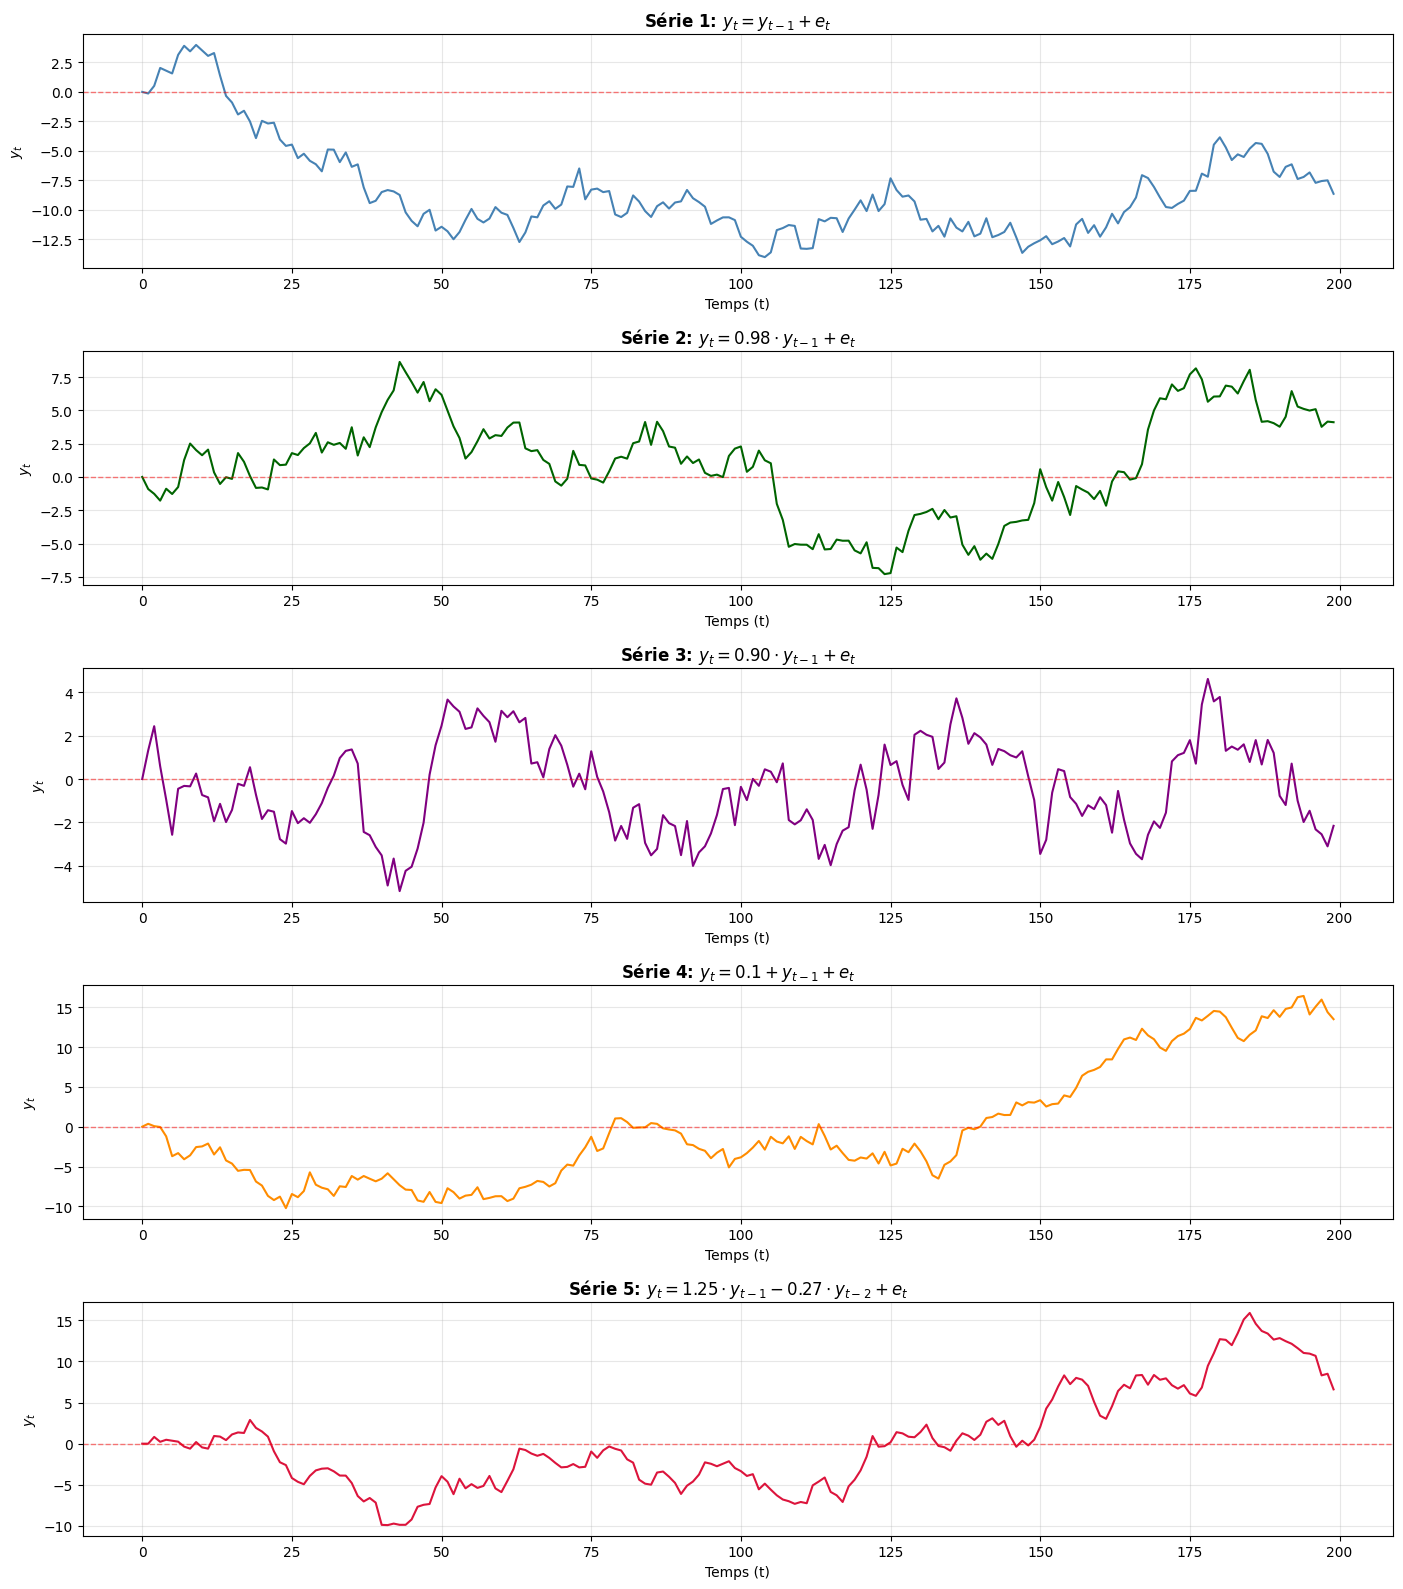

In [51]:
# Graphiques des 5 séries temporelles
fig, axes = plt.subplots(5, 1, figsize=(14, 16))

# Série 1
axes[0].plot(y1, linewidth=1.5, color='steelblue')
axes[0].axhline(y=0, color='red', linestyle='--', linewidth=1, alpha=0.5)
axes[0].set_title('Série 1: $y_t = y_{t-1} + e_t$', fontsize=12, fontweight='bold')
axes[0].set_xlabel('Temps (t)', fontsize=10)
axes[0].set_ylabel('$y_t$', fontsize=10)
axes[0].grid(True, alpha=0.3)

# Série 2
axes[1].plot(y2, linewidth=1.5, color='darkgreen')
axes[1].axhline(y=0, color='red', linestyle='--', linewidth=1, alpha=0.5)
axes[1].set_title('Série 2: $y_t = 0.98 \cdot y_{t-1} + e_t$', fontsize=12, fontweight='bold')
axes[1].set_xlabel('Temps (t)', fontsize=10)
axes[1].set_ylabel('$y_t$', fontsize=10)
axes[1].grid(True, alpha=0.3)

# Série 3
axes[2].plot(y3, linewidth=1.5, color='purple')
axes[2].axhline(y=0, color='red', linestyle='--', linewidth=1, alpha=0.5)
axes[2].set_title('Série 3: $y_t = 0.90 \cdot y_{t-1} + e_t$', fontsize=12, fontweight='bold')
axes[2].set_xlabel('Temps (t)', fontsize=10)
axes[2].set_ylabel('$y_t$', fontsize=10)
axes[2].grid(True, alpha=0.3)

# Série 4
axes[3].plot(y4, linewidth=1.5, color='darkorange')
axes[3].axhline(y=0, color='red', linestyle='--', linewidth=1, alpha=0.5)
axes[3].set_title('Série 4: $y_t = 0.1 + y_{t-1} + e_t$', fontsize=12, fontweight='bold')
axes[3].set_xlabel('Temps (t)', fontsize=10)
axes[3].set_ylabel('$y_t$', fontsize=10)
axes[3].grid(True, alpha=0.3)

# Série 5
axes[4].plot(y5, linewidth=1.5, color='crimson')
axes[4].axhline(y=0, color='red', linestyle='--', linewidth=1, alpha=0.5)
axes[4].set_title('Série 5: $y_t = 1.25 \cdot y_{t-1} - 0.27 \cdot y_{t-2} + e_t$', fontsize=12, fontweight='bold')
axes[4].set_xlabel('Temps (t)', fontsize=10)
axes[4].set_ylabel('$y_t$', fontsize=10)
axes[4].grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

### A - ii 

In [74]:
# Définition modèles AR
ar_models = {
    'Série 1 (AL)': {'phi': [1.0], 'mu': 0},
    'Série 2 (AR(1)) φ=0.98': {'phi': [0.98], 'mu': 0},
    'Série 3 (AR(1)) φ=0.90': {'phi': [0.90], 'mu': 0},
    'Série 4 (AL + dérive)': {'phi': [1.0], 'mu': 0.1},
    'Série 5 (AR(2))': {'phi': [1.25, -0.27], 'mu': 0}
}

# Paramètres de simulation
n_replications = 5000
n_obs = 200
alpha = 0.05 

print(f"Échantillon: {n_obs} observations")

Échantillon: 200 observations


In [75]:
# Simulations Monte-Carlo
def monte_carlo_stationarity_tests(model_name, phi, mu, n_replications=5000, n_obs=200, alpha=0.05):
    rejections = {
        'ADF_c': 0,
        'ADF_ct': 0,
        'KPSS_c': 0,
        'KPSS_ct': 0
    }
    
    for i in range(n_replications):
        # Simulation d'une série AR
        y = simulate_ar(n=n_obs, phi=phi, mu=mu, sigma=1, seed=None)
        
        # Test ADF avec regression='c' 
        try:
            adf_c = adfuller(y, maxlag=2, regression='c', autolag=None)
            # ADF: H0 = racine unitaire, on rejette si stat < valeur critique
            if adf_c[0] < adf_c[4]['5%']:
                rejections['ADF_c'] += 1
        except:
            pass
        
        # Test ADF avec regression='ct'
        try:
            adf_ct = adfuller(y, maxlag=2, regression='ct', autolag=None)
            if adf_ct[0] < adf_ct[4]['5%']:
                rejections['ADF_ct'] += 1
        except:
            pass
        
        # Test KPSS avec regression='c' 
        try:
            kpss_c = kpss(y, regression='c', nlags=2)
            # KPSS: H0 = stationnarité, on rejette si stat > valeur critique
            if kpss_c[0] > kpss_c[3]['5%']:
                rejections['KPSS_c'] += 1
        except:
            pass
        
        # Test KPSS avec regression='ct' 
        try:
            kpss_ct = kpss(y, regression='ct', nlags=2)
            if kpss_ct[0] > kpss_ct[3]['5%']:
                rejections['KPSS_ct'] += 1
        except:
            pass
    
    # Taux de rejets 
    rejection_rates = {
        test: (count / n_replications) * 100
        for test, count in rejections.items()
    }
    
    return rejection_rates

In [76]:
# Exécution simulations Monte Carlo 
results_mc = {}

for model_name, params in ar_models.items():
    results_mc[model_name] = monte_carlo_stationarity_tests(
        model_name=model_name,
        phi=params['phi'],
        mu=params['mu'],
        n_replications=n_replications,
        n_obs=n_obs,
        alpha=alpha
    )

In [92]:
# Tableau taux de rejet
results_df = pd.DataFrame(results_mc).T
results_df = results_df[['ADF_c', 'ADF_ct', 'KPSS_c', 'KPSS_ct']]
results_df.columns = ['ADF (c)', 'ADF (ct)', 'KPSS (c)', 'KPSS (ct)']

print("Taux de rejet hypothèse nulle (en %) par simulation Monte Carlo")
results_df.round(2)

Taux de rejet hypothèse nulle (en %) par simulation Monte Carlo


,ADF (c),ADF (ct),KPSS (c),KPSS (ct)
Série 1 (AL),4.02,4.80,98.72,99.58
Série 2 (AR(1)) φ=0.98,8.54,6.68,95.12,99.28
Série 3 (AR(1)) φ=0.90,76.52,51.80,69.16,89.34
Série 4 (AL + dérive),3.70,5.20,99.32,99.46
Série 5 (AR(2)),11.96,8.42,94.28,98.60


In [96]:
# Tableau comparatif taille et puissance 
size_power_df = pd.DataFrame(index=results_df.index, columns=['ADF (c)', 'ADF (ct)', 'KPSS (c)', 'KPSS (ct)'])

model_types = {
    'Série 1 (AL)': 'non-stat',
    'Série 2 (AR(1)) φ=0.98': 'stat',
    'Série 3 (AR(1)) φ=0.90': 'stat',
    'Série 4 (AL + dérive)': 'non-stat',
    'Série 5 (AR(2))': 'stat'
}

for model, model_type in model_types.items():
    if model_type == 'non-stat':
        size_power_df.loc[model, 'ADF (c)'] = "Taille"
        size_power_df.loc[model, 'ADF (ct)'] = "Taille"
        size_power_df.loc[model, 'KPSS (c)'] = "Puissance"
        size_power_df.loc[model, 'KPSS (ct)'] = "Puissance"
    else:
        size_power_df.loc[model, 'ADF (c)'] = "Puissance"
        size_power_df.loc[model, 'ADF (ct)'] = "Puissance"
        size_power_df.loc[model, 'KPSS (c)'] = "Taille"
        size_power_df.loc[model, 'KPSS (ct)'] = "Taille"

print("Tableau comparatif taille et puissance des 4 tests:")
print("Taille = fréquence à laquelle test rejette Ho alors que Ho est vraie - erreur de type I ")
print( "    (on rejette quand on ne devrait pas)")
print("\nPuissance = fréquence à laquelle test rejette Ho alors que Ho est fausse - erreur de type II")
print("     (on ne rejette pas quand on devrait)")

size_power_df

Tableau comparatif taille et puissance des 4 tests:
Taille = fréquence à laquelle test rejette Ho alors que Ho est vraie - erreur de type I 
    (on rejette quand on ne devrait pas)

Puissance = fréquence à laquelle test rejette Ho alors que Ho est fausse - erreur de type II
     (on ne rejette pas quand on devrait)


,ADF (c),ADF (ct),KPSS (c),KPSS (ct)
Série 1 (AL),Taille,Taille,Puissance,Puissance
Série 2 (AR(1)) φ=0.98,Puissance,Puissance,Taille,Taille
Série 3 (AR(1)) φ=0.90,Puissance,Puissance,Taille,Taille
Série 4 (AL + dérive),Taille,Taille,Puissance,Puissance
Série 5 (AR(2)),Puissance,Puissance,Taille,Taille


## b 

In [98]:
# Extraction des données 
stock_market = pd.read_excel('ie_data.xls', sheet_name='Data', skiprows=7, usecols=[0, 1, 2, 3])

stock_market['Date'] = pd.to_datetime(stock_market['Date'].astype(str).str.replace('.', '-'), format='%Y-%m')

stock_market

,Date,P,D,E
0,1871-01-01,4.44,0.26,0.40
1,1871-02-01,4.5,0.26,0.40
2,1871-03-01,4.61,0.26,0.40
3,1871-04-01,4.74,0.26,0.40
4,1871-05-01,4.86,0.26,0.40
...,...,...,...,...
1829,2023-06-01,4345.372857,68.71,181.17
1830,2023-07-01,4508.0755,NaN,NaN
1831,2023-08-01,4457.358696,NaN,NaN
1832,2023-09-01,4515.77,NaN,NaN


In [100]:
# Transformation log des séries P, D, E
# Nettoyage données
stock_clean = stock_market.copy()
stock_clean['P'] = pd.to_numeric(stock_clean['P'], errors='coerce')
stock_clean['D'] = pd.to_numeric(stock_clean['D'], errors='coerce')
stock_clean['E'] = pd.to_numeric(stock_clean['E'], errors='coerce')
stock_clean = stock_clean.dropna(subset=['P', 'D', 'E'])

P = stock_clean['P'].values
D = stock_clean['D'].values
E = stock_clean['E'].values

log_P = np.log(P)
log_D = np.log(D)
log_E = np.log(E)

df_logs = pd.DataFrame({
    'Date': stock_clean['Date'].values,
    'log_P': log_P,
    'log_D': log_D,
    'log_E': log_E
})

print(f"\nNombre d'observations: {len(df_logs)}")

print(f"\nStatistiques descriptives:")
df_logs[['log_P', 'log_D', 'log_E']].describe()


Nombre d'observations: 1830

Statistiques descriptives:


,log_P,log_D,log_E
count,1830.000000,1830.000000,1830.000000
mean,3.788797,0.540190,1.097386
std,2.105166,1.734526,1.937478
min,1.004302,-1.714798,-1.832581
25%,2.070653,-0.859674,-0.557702
50%,2.892314,-0.074348,0.432741
75%,5.211095,2.042084,2.701249
max,8.449936,4.229895,5.287812


In [101]:
df_logs

,Date,log_P,log_D,log_E
0,1871-01-01,1.490654,-1.347074,-0.916291
1,1871-02-01,1.504077,-1.347074,-0.916291
2,1871-03-01,1.528228,-1.347074,-0.916291
3,1871-04-01,1.556037,-1.347074,-0.916291
4,1871-05-01,1.581038,-1.347074,-0.916291
...,...,...,...,...
1825,2023-02-01,8.313775,4.216267,5.161141
1826,2023-03-01,8.286158,4.222591,5.165757
1827,2023-04-01,8.323965,4.225032,5.177110
1828,2023-05-01,8.329941,4.227466,5.188335


## b - i

In [103]:
# Données pour modèle VAR
data_var = df_logs[['log_P', 'log_D', 'log_E']].values

df_var = pd.DataFrame(data_var, columns=['log_P', 'log_D', 'log_E'])

df_var

,log_P,log_D,log_E
0,1.490654,-1.347074,-0.916291
1,1.504077,-1.347074,-0.916291
2,1.528228,-1.347074,-0.916291
3,1.556037,-1.347074,-0.916291
4,1.581038,-1.347074,-0.916291
...,...,...,...
1825,8.313775,4.216267,5.161141
1826,8.286158,4.222591,5.165757
1827,8.323965,4.225032,5.177110
1828,8.329941,4.227466,5.188335


In [105]:
# Ordre optimal du VAR 
model_var = VAR(df_var)

# Calcul des critères AIC, BIC, etc. pour différents ordres de retard
lag_order_results = model_var.select_order(maxlags=12)

print(f"Ordre optimal selon BIC: {lag_order_results.bic}")

Ordre optimal selon BIC: 5


In [108]:
# Estimation Modèle VAR 
optimal_lag = lag_order_results.bic

print(f"Ordre optimal selon BIC: {optimal_lag}")

var_model = model_var.fit(optimal_lag)

print("\nRésumé modèle VAR")
print(var_model.summary())

Ordre optimal selon BIC: 5

Résumé modèle VAR
  Summary of Regression Results   
Model:                         VAR
Method:                        OLS
Date:           Sun, 14, Dec, 2025
Time:                     15:30:06
--------------------------------------------------------------------
No. of Equations:         3.00000    BIC:                   -24.6410
Nobs:                     1825.00    HQIC:                  -24.7325
Log likelihood:           14896.5    FPE:                1.72036e-11
AIC:                     -24.7859    Det(Omega_mle):     1.67589e-11
--------------------------------------------------------------------
Results for equation log_P
              coefficient       std. error           t-stat            prob
---------------------------------------------------------------------------
const            0.023636         0.010390            2.275           0.023
L1.log_P         1.284801         0.023624           54.385           0.000
L1.log_D        -0.186183         

Hypothèse nulle (H₀): La variable X ne Granger-cause pas la variable Y

Rejeter H₀ si p-value < 0.05 (niveau 5%)

In [109]:
# Est-ce que log_P Granger-cause log_D?
print("H₀: log_P ne Granger-cause pas log_D\n")

# Préparation des données: [variable dépendante, variable causale]
data_P_to_D = df_var[['log_D', 'log_P']]

# Test avec maxlag = ordre du VAR
gc_P_to_D = grangercausalitytests(data_P_to_D, maxlag=optimal_lag, verbose=True)

H₀: log_P ne Granger-cause pas log_D


Granger Causality
number of lags (no zero) 1
ssr based F test:         F=78.7544 , p=0.0000  , df_denom=1826, df_num=1
ssr based chi2 test:   chi2=78.8838 , p=0.0000  , df=1
likelihood ratio test: chi2=77.2300 , p=0.0000  , df=1
parameter F test:         F=78.7544 , p=0.0000  , df_denom=1826, df_num=1

Granger Causality
number of lags (no zero) 2
ssr based F test:         F=17.8605 , p=0.0000  , df_denom=1823, df_num=2
ssr based chi2 test:   chi2=35.8189 , p=0.0000  , df=2
likelihood ratio test: chi2=35.4725 , p=0.0000  , df=2
parameter F test:         F=17.8605 , p=0.0000  , df_denom=1823, df_num=2

Granger Causality
number of lags (no zero) 3
ssr based F test:         F=14.0354 , p=0.0000  , df_denom=1820, df_num=3
ssr based chi2 test:   chi2=42.2681 , p=0.0000  , df=3
likelihood ratio test: chi2=41.7865 , p=0.0000  , df=3
parameter F test:         F=14.0354 , p=0.0000  , df_denom=1820, df_num=3

Granger Causality
number of lags (no zero) 4
ssr 

In [110]:
# Est-ce que log_P Granger-cause log_E?
print("H₀: log_P ne Granger-cause pas log_E\n")

data_P_to_E = df_var[['log_E', 'log_P']]
gc_P_to_E = grangercausalitytests(data_P_to_E, maxlag=optimal_lag, verbose=True)

H₀: log_P ne Granger-cause pas log_E


Granger Causality
number of lags (no zero) 1
ssr based F test:         F=7.8911  , p=0.0050  , df_denom=1826, df_num=1
ssr based chi2 test:   chi2=7.9041  , p=0.0049  , df=1
likelihood ratio test: chi2=7.8871  , p=0.0050  , df=1
parameter F test:         F=7.8911  , p=0.0050  , df_denom=1826, df_num=1

Granger Causality
number of lags (no zero) 2
ssr based F test:         F=24.0786 , p=0.0000  , df_denom=1823, df_num=2
ssr based chi2 test:   chi2=48.2892 , p=0.0000  , df=2
likelihood ratio test: chi2=47.6624 , p=0.0000  , df=2
parameter F test:         F=24.0786 , p=0.0000  , df_denom=1823, df_num=2

Granger Causality
number of lags (no zero) 3
ssr based F test:         F=21.8097 , p=0.0000  , df_denom=1820, df_num=3
ssr based chi2 test:   chi2=65.6809 , p=0.0000  , df=3
likelihood ratio test: chi2=64.5278 , p=0.0000  , df=3
parameter F test:         F=21.8097 , p=0.0000  , df_denom=1820, df_num=3

Granger Causality
number of lags (no zero) 4
ssr 

In [111]:
# Est-ce que log_E Granger-cause log_P?
print("H₀: log_E ne Granger-cause pas log_P\n")

data_E_to_P = df_var[['log_P', 'log_E']]
gc_E_to_P = grangercausalitytests(data_E_to_P, maxlag=optimal_lag, verbose=True)

H₀: log_E ne Granger-cause pas log_P


Granger Causality
number of lags (no zero) 1
ssr based F test:         F=2.9379  , p=0.0867  , df_denom=1826, df_num=1
ssr based chi2 test:   chi2=2.9427  , p=0.0863  , df=1
likelihood ratio test: chi2=2.9404  , p=0.0864  , df=1
parameter F test:         F=2.9379  , p=0.0867  , df_denom=1826, df_num=1

Granger Causality
number of lags (no zero) 2
ssr based F test:         F=4.9508  , p=0.0072  , df_denom=1823, df_num=2
ssr based chi2 test:   chi2=9.9288  , p=0.0070  , df=2
likelihood ratio test: chi2=9.9020  , p=0.0071  , df=2
parameter F test:         F=4.9508  , p=0.0072  , df_denom=1823, df_num=2

Granger Causality
number of lags (no zero) 3
ssr based F test:         F=3.6691  , p=0.0119  , df_denom=1820, df_num=3
ssr based chi2 test:   chi2=11.0495 , p=0.0115  , df=3
likelihood ratio test: chi2=11.0162 , p=0.0116  , df=3
parameter F test:         F=3.6691  , p=0.0119  , df_denom=1820, df_num=3

Granger Causality
number of lags (no zero) 4
ssr 

In [112]:
# Est-ce que log_E Granger-cause log_D ?
print("H₀: log_E ne Granger-cause pas log_D\n")

data_E_to_D = df_var[['log_D', 'log_E']]
gc_E_to_D = grangercausalitytests(data_E_to_D, maxlag=optimal_lag, verbose=True)

H₀: log_E ne Granger-cause pas log_D


Granger Causality
number of lags (no zero) 1
ssr based F test:         F=659.1634, p=0.0000  , df_denom=1826, df_num=1
ssr based chi2 test:   chi2=660.2464, p=0.0000  , df=1
likelihood ratio test: chi2=563.7172, p=0.0000  , df=1
parameter F test:         F=659.1634, p=0.0000  , df_denom=1826, df_num=1

Granger Causality
number of lags (no zero) 2
ssr based F test:         F=43.1256 , p=0.0000  , df_denom=1823, df_num=2
ssr based chi2 test:   chi2=86.4877 , p=0.0000  , df=2
likelihood ratio test: chi2=84.5040 , p=0.0000  , df=2
parameter F test:         F=43.1256 , p=0.0000  , df_denom=1823, df_num=2

Granger Causality
number of lags (no zero) 3
ssr based F test:         F=29.5490 , p=0.0000  , df_denom=1820, df_num=3
ssr based chi2 test:   chi2=88.9879 , p=0.0000  , df=3
likelihood ratio test: chi2=86.8886 , p=0.0000  , df=3
parameter F test:         F=29.5490 , p=0.0000  , df_denom=1820, df_num=3

Granger Causality
number of lags (no zero) 4
ssr 

In [116]:
# Tableau récapitulatif résultats de causalité de Granger
def extract_granger_pvalues(gc_results, maxlag):
    pvalues = {}
    for lag in range(1, maxlag + 1):
        pvalue = gc_results[lag][0]['ssr_ftest'][1]
        pvalues[lag] = pvalue
    return pvalues

# p-values
pvalues_P_to_D = extract_granger_pvalues(gc_P_to_D, optimal_lag)
pvalues_P_to_E = extract_granger_pvalues(gc_P_to_E, optimal_lag)
pvalues_E_to_P = extract_granger_pvalues(gc_E_to_P, optimal_lag)
pvalues_E_to_D = extract_granger_pvalues(gc_E_to_D, optimal_lag)

summary_df = pd.DataFrame({
    'P gc D': [pvalues_P_to_D[lag] for lag in range(1, optimal_lag + 1)],
    'P gc E': [pvalues_P_to_E[lag] for lag in range(1, optimal_lag + 1)],
    'E gc P': [pvalues_E_to_P[lag] for lag in range(1, optimal_lag + 1)],
    'E gc D': [pvalues_E_to_D[lag] for lag in range(1, optimal_lag + 1)]
}, index=[f'Lag {i}' for i in range(1, optimal_lag + 1)])

print("P-values tests de causalité de Granger (rejeter H₀ si p < 0.05)")
print("gc: granger cause")
summary_df.round(4)

P-values tests de causalité de Granger (rejeter H₀ si p < 0.05)
gc: granger cause


,P gc D,P gc E,E gc P,E gc D
Lag 1,0.0,0.005,0.0867,0.0
Lag 2,0.0,0.000,0.0072,0.0
Lag 3,0.0,0.000,0.0119,0.0
Lag 4,0.0,0.000,0.0200,0.0
Lag 5,0.0,0.000,0.0214,0.0
